In [40]:
import os, sys
os.chdir('/home/koritskiy/rqc/hamiltonian_learning')
from random import seed
from modules.main import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def to_basis(angles):
    v = np.cos(angles[0] / 2)
    w = np.sin(angles[0] / 2) * np.exp(1j*angles[1])
    b = np.array([v, w]).reshape(2, 1)
    
    return b @ b.T.conj()

In [3]:
def double_plot(Y1, Y2, Y1_name=None, Y2_name=None):

    X = range(len(Y1))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('iterations')
    if Y1_name:
        ax1.set_ylabel(Y1_name, color=color)
    else:
        ax1.set_ylabel("Y1", color=color)
    ax1.scatter(X, Y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    if Y1_name:
        ax2.set_ylabel(Y2_name, color=color)
    else:
        ax2.set_ylabel("Y2", color=color)  # we've already handled the x-label with ax1
    ax2.scatter(X, Y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

In [4]:
def num_der(angles):
    
    d_angles = angles * 10 ** - 4
    grad  = np.zeros((n_spins, 2))
    for s in range(n_spins):
        for a in range(2):
            new_angles = np.copy(angles)
            new_angles[s, a] += d_angles[s, a]

            s_t, c_t = hamiltonian_t.measure(angles)
            s_g, c_g = hamiltonian_g.measure(angles)
            distance = distance_by_measurements(s_t, s_g, c_t, c_g)

            d_s_t, d_c_t = hamiltonian_t.measure(new_angles)
            d_s_g, d_c_g = hamiltonian_g.measure(new_angles)
            d_distance = distance_by_measurements(d_s_t, d_s_g, d_c_t, d_c_g)

            grad[s, a] = (d_distance - distance) / d_angles[s, a]
    return grad

In [79]:
# Some initial parameters
np.random.seed(40)
seed(40)

eps = 10 ** - 1

n_spins = 2
beta = 0.3
cycles = 300

lr = 0.8
gradient_iterations = 1

"""Random inintial angles"""
# Create initial random basis angles
theta = np.random.rand(n_spins) * np.pi
phi = np.random.rand(n_spins) * 2 * np.pi

angles_0 = np.array([theta, phi]).T
"""Specific initial angles"""
# angles_0 = np.array([[np.pi/2-eps, eps], [np.pi/2+eps, -eps]]) 
# angles_0 = np.array([[np.pi/2, 0], [1.58449883, 0]]) 
# angles_0 = np.array([[np.pi/2, 0]]) 


"""Fields and couplings"""
# xx_t = [1]
# yy_t = []
# z_t = [-1, -1]
# x_t = [-1, -1]

# xx_g = [-1]
# yy_g = [-1]
# z_g = [-1, -1]
# x_g = [1, 1]


xx_t, yy_t, zz_t = np.random.rand(3, n_spins - 1)
xx_g, yy_g, zz_g = np.random.rand(3, n_spins - 1)
x_t, y_t, z_t = np.random.rand(3, n_spins)
x_g, y_g, z_g = np.random.rand(3, n_spins)

                                  

"""Initiate hamiltonians"""
hamiltonian_t = Hamiltonian(n_spins, beta, z=z_t, x=x_t, xx=xx_t, yy=yy_t)
# hamiltonian_t = Hamiltonian(n_spins, beta, xx=xx_t, yy=yy_t)
# hamiltonian_t = Hamiltonian(n_spins, beta, x=x_t, z=z_t)
hamiltonian_t.set_density_mat()

hamiltonian_g = Hamiltonian(n_spins, beta, z=z_g, x=x_g, xx=xx_g, yy=yy_g)
# hamiltonian_g = Hamiltonian(n_spins, beta, xx=xx_g, yy=yy_g)
# hamiltonian_g = Hamiltonian(n_spins, beta, x=x_g, z=z_g)
hamiltonian_g.set_density_mat();
# print(hamiltonian_t.density_mat)
# print(hamiltonian_g.density_mat)

In [93]:
"""For singles"""
spin_n = 1
S = hamiltonian_t.density_mat
s = ReducedMatrixMeasurement.reduced_matrix(S, spin_n, spin_n)

theta = angles_0[spin_n, 0] + np.pi 
phi = angles_0[spin_n, 1]

A = 1 / 2 - s[0, 0]
B = np.real(s[0, 1] * np.exp(1j * phi))
C = np.imag(s[0, 1] * np.exp(1j * phi))

print('Manual grad')
print(f'd_theta:{A * np.sin(theta) + B * np.cos(theta)}')
print(f'd_phi:{- C * np.sin(theta)}')

Manual grad
d_theta:(0.15496275369282247+0j)
d_phi:-0.014066185769588355


In [151]:
"""For doubles"""
print('Manual grad\n')
ZZ = np.copy(angles_0)

XZ = np.copy(angles_0)
XZ[0, 0] += np.pi / 2

YZ = np.copy(angles_0)
YZ[0, 0] = np.pi / 2
YZ[0, 1] += np.pi / 2

spin_n = 0
D = hamiltonian_t.density_mat
Id = np.eye(2)
theta = angles_0[spin_n, 0] #+ np.pi 
phi = angles_0[spin_n, 1]


# Approach 1
print('Approach 1')
ang = ZZ[(spin_n + 1) % 2] #+ np.array([np.pi, 0])
if spin_n == 0:
    basis = np.kron(Id, to_basis(ang)) 
else:
    basis = np.kron(to_basis(ang), Id)

d = ReducedMatrixMeasurement.reduced_matrix(D @ basis, spin_n, spin_n)
print(f'pxz: {np.trace(d @ to_basis(XZ[0]))}')

A = 1 / 2 - d[0, 0]
B = np.real(d[0, 1] * np.exp(1j * phi))
C = np.imag(d[0, 1] * np.exp(1j * phi))
print(f'd_theta:{A * np.sin(theta) + B * np.cos(theta)}')
# print(f'd_phi:{- C * np.sin(theta)}')
print('')
z
# # Approach 2
# print('Approach 2')
# pxz = np.trace(D @ np.kron(to_basis(XZ[0]), to_basis(XZ[1])))
# print(f'pxz: {pxz}')
# # pyz = np.trace(D @ to_basis(Y))
# # # print(pxz)
# # # print(pyz)
# print(f'd_theta:{np.real(pxz - 1 / 2)}')

Manual grad

Approach 1
pxz: (0.2408023849599513-3.2526065174565133e-19j)
d_theta:(0.2395534262794577+0j)

Approach 2
pxz: (0.24080238495995127-3.2526065174565133e-19j)
d_theta:-0.25919761504004873


In [132]:
rho = hamiltonian_t.density_mat
angles0 = angles_0[0] + np.array([np.pi / 2, 0])
angles1 = angles_0[1]
basis0 = to_basis(angles0)
basis1 = to_basis(angles1)
basis = np.kron(basis0, basis1)

pxz = np.real(np.trace(rho @ basis))


0.24080238495995127

In [25]:
angles_r = np.copy(angles_0)
angles_r[0] = np.array([0,0])
D = hamiltonian_t.rotation(angles_r)

b = to_spin(np.array([0,0]))
basis = b @ b.T.conj()
Id = np.eye(2)
basis = np.kron(Id, basis)
D = D @ basis
d = ReducedMatrixMeasurement.reduced_matrix(D, 0, 0)
print(d)
print(np.trace(d))
print('Manual grad')
print(f'A:{1/2-d[0, 0]}')
print(f'B:{np.real(d[0, 1] * np.exp(1j * angles_0[0,1]))}')
print(f'С:{np.imag(d[0, 1] * np.exp(1j * angles_0[0,1]))}')

NameError: name 'to_spin' is not defined

In [80]:
"""Analytical gradient"""

angles = np.copy(angles_0)
X = np.linspace(1, cycles, cycles)
Angles = np.zeros((cycles, n_spins, 2))
Distance = np.zeros(cycles)

# Angles[0] = angles
# singles_t, correlators_t = hamiltonian_t.measure(angles)
# singles_g, correlators_g = hamiltonian_g.measure(angles)

# Distance[0] = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
print('Analytical gradient')
for i in tqdm(range(cycles)):
    grad = Gradient(hamiltonian_t, hamiltonian_g, angles)
    angles = grad.gradient_descent(lr=lr, num_iterations=gradient_iterations)
#     angles += lr * num_der(angles)
    singles_t, correlators_t = hamiltonian_t.measure(angles)
    singles_g, correlators_g = hamiltonian_g.measure(angles)

#     print(f"singles_t {singles_t}")
#     print(f"singles_g {singles_g}")
    distance = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)

    Angles[i] = angles
    Distance[i] = distance


Analytical gradient


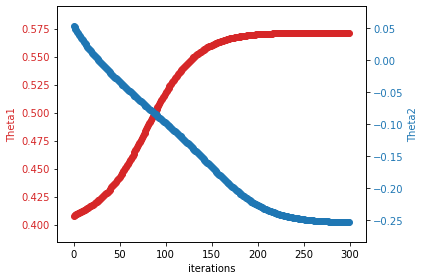

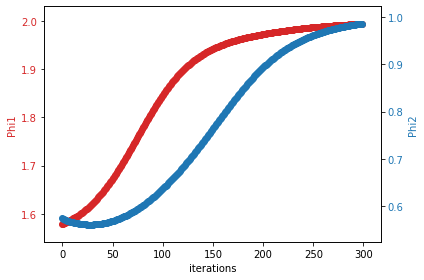

0.010778727772680215


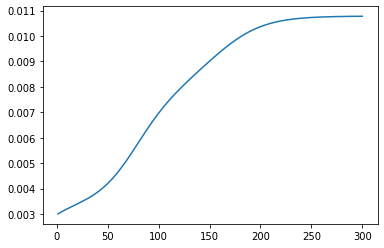

In [81]:
P_angles = Angles / np.pi  # Angles for drawing
double_plot(P_angles[:, 0, 0], P_angles[:, 1, 0], "Theta1", "Theta2")
double_plot(P_angles[:, 0, 1], P_angles[:, 1, 1], "Phi1", "Phi2")
plt.plot(X, Distance)
print(Distance[-1])

In [37]:
"""Numerical gradient"""
angles = np.copy(angles_0)
X = np.linspace(1, cycles, cycles)
Angles = np.zeros((cycles, n_spins, 2))
Distance = np.zeros(cycles)

Angles[0] = angles
singles_t, correlators_t = hamiltonian_t.measure(angles)
singles_g, correlators_g = hamiltonian_g.measure(angles)

Distance[0] = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
print('Numerical')
for i in tqdm(range(1, cycles)):
#     grad = Gradient(hamiltonian_t, hamiltonian_g, angles)
#     angles = grad.gradient_descent(lr=lr, num_iterations=gradient_iterations)
    grad_step = lr * num_der(angles) *10
    angles += grad_step
    print(num_der(angles))
    singles_t, correlators_t = hamiltonian_t.measure(angles)
    singles_g, correlators_g = hamiltonian_g.measure(angles)


    distance = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
    
    Angles[i] = angles
    Distance[i] = distance



Numerical


[[ 0.01316539 -0.00883195]
 [-0.00355496  0.00938692]]
[[ 0.00752386 -0.00051917]
 [-0.00181767  0.00175388]]
[[ 0.00418972 -0.00005747]
 [-0.00104047  0.00682633]]
[[ 0.00232167  0.0005278 ]
 [-0.00051021 -0.00164492]]
[[ 0.00116006 -0.00904599]
 [-0.00040592  0.00253594]]
[[ 0.00090167  0.00056514]
 [-0.00007455 -0.00000569]]
[[ 0.00041387  0.00069925]
 [-0.00010478 -0.00813341]]
[[ 0.00017117 -0.00196644]
 [-0.00000809  0.00366148]]
[[ 0.00009658 -0.00116383]
 [-0.00002231 -0.00132849]]
[[ 0.00003689 -0.00191485]
 [ 0.00001677 -0.00156182]]
[[ 0.00011603 -0.00104608]
 [ 0.00002327 -0.00078732]]
[[-0.00002158  0.00187278]
 [-0.00003137  0.00720158]]
[[-0.00000999  0.00573517]
 [-0.00002026 -0.00126371]]
[[-0.00006121  0.00046257]
 [-0.00003642  0.00042948]]
[[ 0.00001144  0.00072347]
 [-0.00001293  0.00069421]]
[[ 0.00002428  0.00115926]
 [-0.00001844  0.00046706]]
[[ 0.00000046  0.00159298]
 [-0.0000471   0.0015567 ]]
[[-0.0000744  -0.00570875]
 [-0.00004555 -0.00629869]]
[[-0.00001

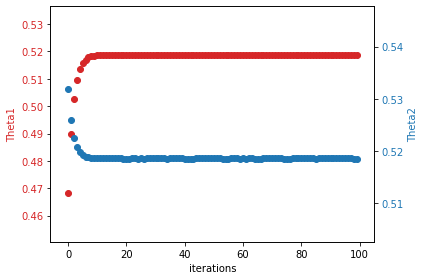

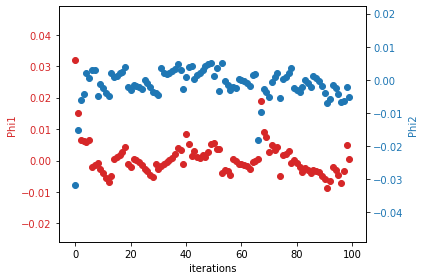

0.13200830044083578

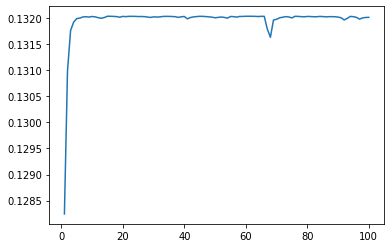

In [38]:
P_angles = Angles / np.pi  # Angles for drawing
double_plot(P_angles[:, 0, 0], P_angles[:, 1, 0], "Theta1", "Theta2")
double_plot(P_angles[:, 0, 1], P_angles[:, 1, 1], "Phi1", "Phi2")
plt.plot(X, Distance)
Distance[-1]

In [94]:
angles = Angles[-1]
# angles = np.array([[np.pi/2, 0],[np.pi/2, 0]])

singles_t, correlators_t = hamiltonian_t.measure(angles)
singles_g, correlators_g = hamiltonian_g.measure(angles)

distance = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
print(distance)

0.13121936184949443


In [46]:
Angles[-1]

array([[ 1.58449883, -0.        ],
       [ 1.58449883, -0.        ]])